- [Data Set](https://figshare.com/articles/dataset/EEG_Data_New/4244171/2) 
- [Paper](https://ieeexplore.ieee.org/document/9995246)

'H' stands for Healthy Controls
'MDD' stands for Major Depressive Disorder 
'EC' stands for eyes closed
'EO' stands for eyes open
'TASK' stands for P300 data

The 19-electrodes covering the scalp included the frontal (Fp1,
Fp2, F3, F4, F7, F8, Fpz), temporal (T3, T4, T5, T6), parietal (P3, P4,
P7, P8), occipital (O1, O2), and central (C3, C4) regions. Moreover,
the 19-channels EEG cap was attached to an amplifier from Brain
Master Systems with configurations such as 0.5 Hz to 70 Hz filter,
with a 50 Hz notch filter, and a sample rate of 256 samples per second

In [18]:
%matplotlib inline
import warnings
import os as os
import mne
mne.set_log_level('error')
import re
import matplotlib
from mne.io import concatenate_raws, read_raw_edf
import numpy as np
import sys
sys.path.append("./../data/") # add the data package directory to the python path to be able to import data_methods.py module
from data_methods import *
matplotlib.use('agg')
# print(sys.path)

In [19]:
# load data. Functions from helper class data_methods.py
# preload is set to `False`
raw_H_data = get_raw_H_data()
raw_MDD_data = get_raw_MDD_data()

In [20]:
## explore loaded data structure
# print(type(raw_H_data))
# print(type(raw_MDD_data))

# index into raw data dict for healthy patients (EC,EO,P300(TASK) RawEDF objects)

raw_HEC_1 = raw_H_data[0][0][0]  
raw_HEO_1 = raw_H_data[0][0][1] 
raw_HP300_1 = raw_H_data[0][0][2]

In [21]:
raw_HEC_1_info = raw_HEC_1.info
raw_HEC_1_info

# We can see that the data are bandpass filtered 0.50Hz/80Hz lower and upper cutoffs


<Info | 7 non-empty values
 bads: []
 ch_names: Fp1-LE, F3-LE, C3-LE, P3-LE, O1-LE, F7-LE, T3-LE, T5-LE, Fz-LE, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 80.0 Hz
 meas_date: 2011-08-16 17:48:54 UTC
 nchan: 22
 projs: []
 sfreq: 256.0 Hz
>

In [22]:
# available attributes in info object
raw_HEC_1_info.keys()

# channel names
ch_names = raw_HEC_1_info['ch_names']

print(ch_names)

['Fp1-LE', 'F3-LE', 'C3-LE', 'P3-LE', 'O1-LE', 'F7-LE', 'T3-LE', 'T5-LE', 'Fz-LE', 'Fp2-LE', 'F4-LE', 'C4-LE', 'P4-LE', 'O2-LE', 'F8-LE', 'T4-LE', 'T6-LE', 'Cz-LE', 'Pz-LE', 'A2-A1', '23A-23R', '24A-24R']


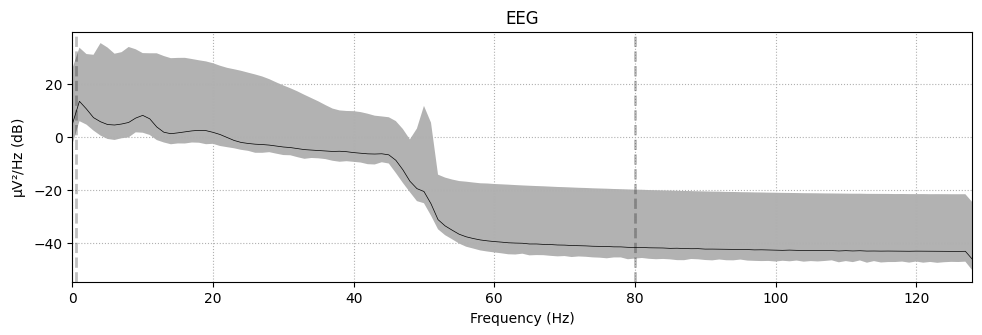

In [23]:
# plot psds (bandpass filtered data*)

raw_HEC_1.compute_psd(method='welch').plot(average=True, ci = 'range')

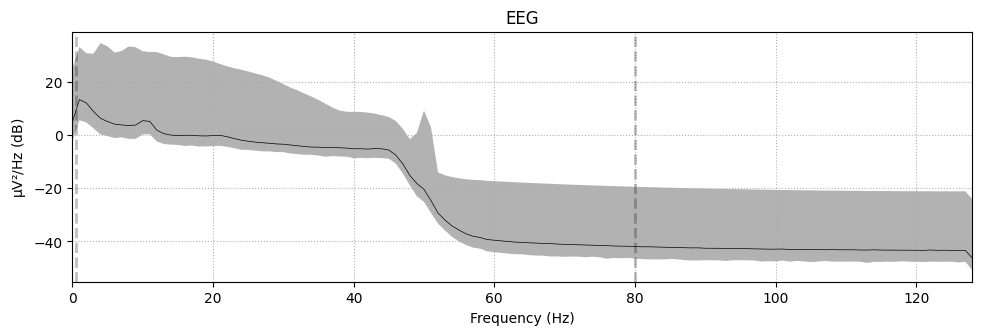

In [24]:
raw_HEO_1.compute_psd(method='welch').plot(average=True, ci = 'range')

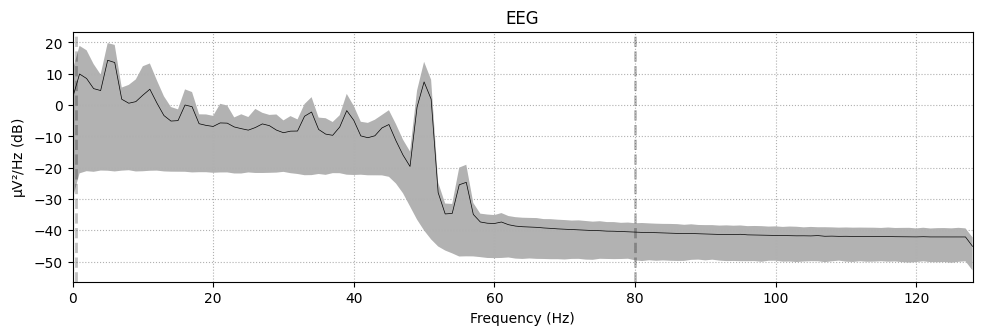

In [25]:
raw_HP300_1.compute_psd(method='welch').plot(average=True, ci = 'range')

['Fp1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'Fz', 'Fp2', 'F4', 'C4', 'P4', 'O2', 'F8', 'T4', 'T6', 'Cz', 'Pz', 'A2', '23A', '24A']


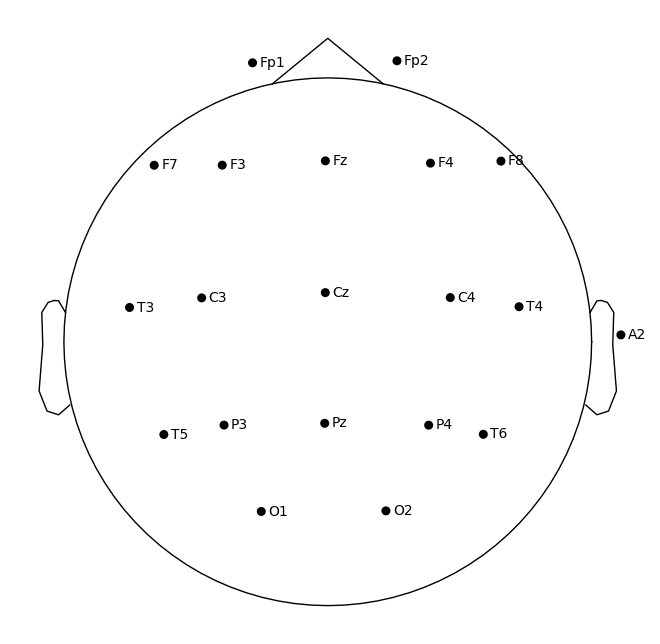

In [26]:
# basic sensor plot

# remove reference electrode from name to match names in standard 10-20 montage
fixed_ch_names = []
for ch_name in ch_names:
    fixed_name = re.sub('-\w+', '', ch_name) # remove suffix
    fixed_ch_names.append(fixed_name)

print(fixed_ch_names)

# Form the 10-20 montage 
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep
ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in fixed_ch_names]
# Keep only the desired channels
mont1020.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020.dig = mont1020.dig[0:3]+kept_channel_info
mont1020.plot()

In [27]:
# default SSPs (none present)
projectors = raw_HEC_1_info['projs']
print(len(projectors))

0


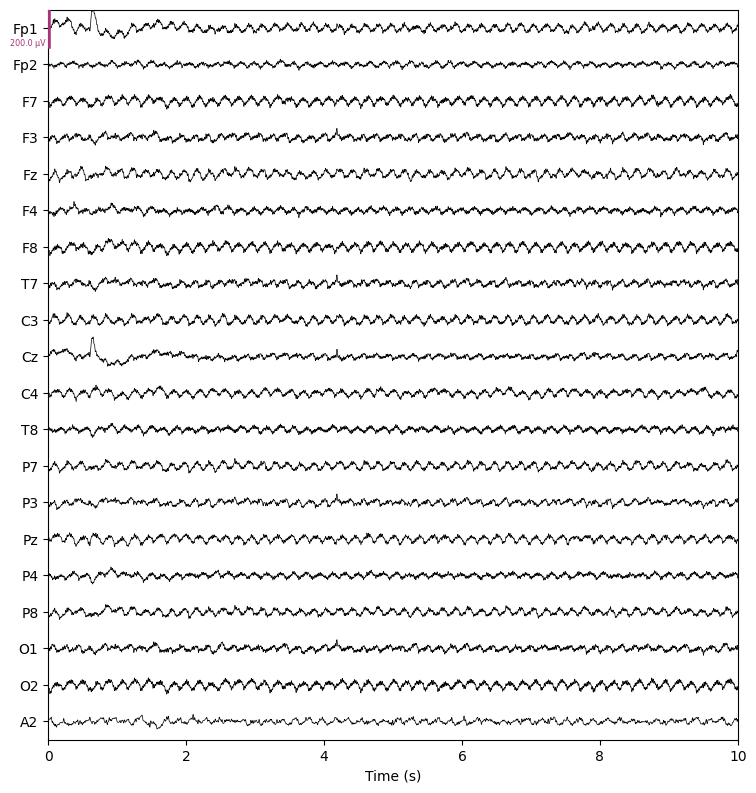

In [28]:
# Creating raw object and corresponding info object from scratch (testing algorithm for single EDF file (TASK))
from mne.io import RawArray
montage = mne.channels.make_standard_montage('standard_1020')

info = mne.create_info(ch_names=['Fp1','Fp2','F7','F3','Fz','F4','F8','T7',
                                 'C3','Cz','C4','T8','P7','P3','Pz','P4','P8',
                                 'O1','O2', 'A2', '23A', '24A'],
                        sfreq=256., ch_types='eeg')
info.set_montage(montage, on_missing = 'warn')

raw_edf = raw_HP300_1

eeg_data = raw_edf.get_data(picks='eeg')


# dimensions of data ; (n_channels, n_timepoints) ndarray
eeg_data.shape

# create raw array with constructed info object and extracted data from TASK edf file for first subject
raw_ica = mne.io.RawArray(data=eeg_data, info = info)

raw_ica.plot(show_scrollbars=False,
            scalings=dict(eeg=100e-6))

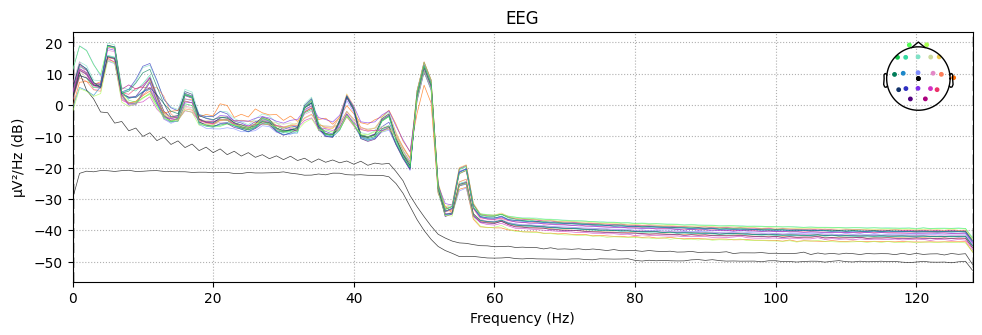

In [29]:

# ensure constructed array has the same spectrum as raw_HP300_1
raw_ica.compute_psd(method='welch').plot(average=False, ci='range', ci_alpha = 0.25,
                                         spatial_colors=True)

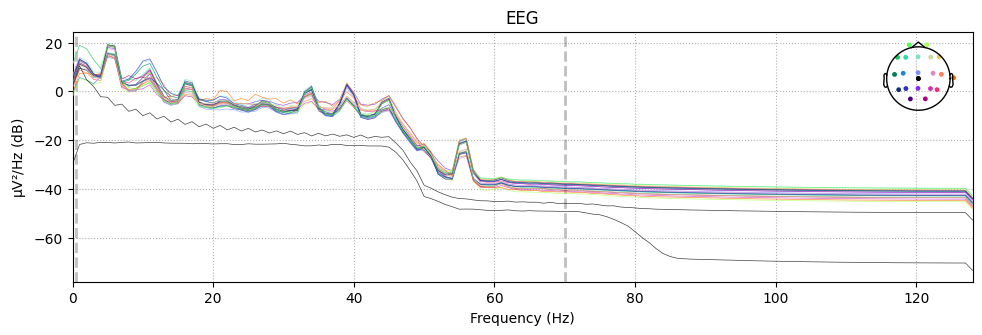

In [30]:
# lowpass filter cutoff at 70 hz

filtered_ica = filter_raw_data(raw_ica.copy())

filtered_ica.compute_psd(method='welch').plot(average=False, ci='range', ci_alpha = 0.25,
                                         spatial_colors=True)
# save filtered data to new file
# filtered_ica.save('filtered__pre_ICA_eeg.fif', overwrite=True)    



In [31]:
# make arbitrary events with duration 1s in order to epoch data
# epoched (segmented) data works better with ICA due to higher SNR, lower noise contamination, more stationary signal
# for testing purposes the choice for `tstep` is arbitrary, this may or may not improve accuracy of analysis
tstep = .5
events_ica = mne.make_fixed_length_events(filtered_ica, duration=tstep)
epochs_ica = mne.Epochs(filtered_ica, events_ica, tmin=0., tmax = tstep,
                        baseline=None,
                        preload=True)


In [32]:
from autoreject import get_rejection_threshold

# automatically determine threshold above which data is considered to be excessively noisy
# `get_rejection_threshold` requires mne.Epochs
reject = get_rejection_threshold(epochs_ica)
reject

Estimating rejection dictionary for eeg


{'eeg': 0.00032132771828129295}

In [33]:
random_state = 42
ica_n_components = .99

ica = mne.preprocessing.ICA(n_components = ica_n_components,
                            random_state=random_state)
ica.fit(epochs_ica,
        reject =reject,
        tstep=tstep)

Method,fastica
Fit,18 iterations on epochs (155961 samples)
ICA components,14
Available PCA components,22
Channel types,eeg
ICA components marked for exclusion,—


In [3]:
import os
from pathlib import Path
import mne

filename = 'MDDS5EO'
data_dir = os.path.abspath('../../data')

ic_file = str(Path(data_dir, 'processed', 'IC', f'{filename}_ica.fif').resolve())
raw_file = str(Path(data_dir, 'raw', f'{filename}.edf').resolve())

raw = mne.io.read_raw_edf(raw_file)
ica = mne.preprocessing.read_ica(ic_file)

# raw.info['chs']



# ica.plot_overlay(raw, picks='eeg')

rawsc = mne.io.read_raw_fif(str(Path(data_dir, 'processed', 'RawObjects', f'{filename}_scaled.fif').resolve()))

rawsc.info

Extracting EDF parameters from /home/mahds21/GNN_EEG/data/raw/MDDS5EO.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading /home/mahds21/GNN_EEG/data/processed/IC/MDDS5EO_ica.fif ...
Now restoring ICA solution ...
Ready.
Opening raw data file /home/mahds21/GNN_EEG/data/processed/RawObjects/MDDS5EO_scaled.fif...
    Range : 0 ... 77311 =      0.000 ...   301.996 secs
Ready.


/tmp/ipykernel_4786/1743663250.py:20: RuntimeWarning: This filename (/home/mahds21/GNN_EEG/data/processed/RawObjects/MDDS5EO_scaled.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  rawsc = mne.io.read_raw_fif(str(Path(data_dir, 'processed', 'RawObjects', f'{filename}_scaled.fif').resolve()))


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, T7, C3, Cz, C4, T8, P7, P3, Pz, ...
 chs: 22 EEG
 custom_ref_applied: False
 dig: 23 items (3 Cardinal, 20 EEG)
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 lowpass: 70.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 22
 projs: []
 sfreq: 256.0 Hz
>

In [35]:
# ica.plot_components()

ValueError: The following electrodes have overlapping positions, which causes problems during visualization:
23A, 24A

In [ ]:
hi_cut = 70
# ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': hi_cut})
ica.plot_properties(epochs_ica, picks=range(0,ica.n_components_), log_scale=True)

In [ ]:
# correlation analysis to detect EOG related components
# results are based on pearson correlation coefficients between the epoched data (filtered) and the channels most likely to pick up eye artifacts
# note that only one channel required per hemisphere (standard 10-20 montage)
ica_z_thresh = 1.96
eog_indices, eog_scores = ica.find_bads_eog(epochs_ica,
                                            ch_name=['Fp1', 'F8'],
                                            threshold=ica_z_thresh)

ica.exclude = eog_indices

ica.plot_scores(eog_scores)

In [ ]:
ica.plot_sources(raw_ica, show_scrollbars=False)

In [ ]:
print(type(HS10[0]))
ica.plot_overlay(HS10[0], picks='eeg')

In [ ]:
# check formatting of raw HS16EC.edf file
HS16 = get_individual_data(16,'H')
print(HS16)
HS16[0].info['ch_names']
# HS16[0].plot(scalings=dict(eeg=100e-6))

In [ ]:
# check formatting of raw HS10EC.edf file
HS10 = get_individual_data(10,'H')
print(HS10)
HS10[0].info['ch_names']
# HS10[0].plot(scalings=dict(eeg=100e-6))

In [ ]:
all_raw_H = get_raw_H_data()
for key, values in all_raw_H.items():
    # check if the key is an integer
    if isinstance(key, int):
        # extract the first element of the list and print it
        print(values[0])

In [ ]:
# check for missing files in healthy dataset

# import warnings
all_raw_H = get_raw_H_data()

for key, values in all_raw_H.items():
    # check if the key is an integer
    if isinstance(key, int):
        # extract the first element of the list
        text = str(values[0])
        # find all matches for the desired pattern
        time_matches = re.findall(r'\(\d{3}\.\d?\ss\)', text)
        file_matches = re.findall(r'\S+\.edf', text)

        # check if there are less than 3 time matches
        if len(file_matches) < 3:
            # raise warning
            # warnings.warn(f'Not enough files found for subject {key}.')
            print(f'Subject {key}: Only {len(file_matches)} file matches found.')
            print(f'files - {file_matches}')
        # elif len(file_matches) == 3:
        #     # print the matches
        #     print(f'Subject {key}: Appropriate number of files found ({len(file_matches)}).')
        #     print(f'matches - {file_matches}')